(test-functions:flood)=
# Flood Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uqtestfuns as uqtf

The flood model is an eight-dimensional scalar valued function.
The model was used in the context of sensitivity analysis in {cite}`Iooss2015, Lamboni2013`
and has become a canonical example of the OpenTURNS package {cite}`Baudin2017`.

## Test function instance

To create a default instance of the flood model:

In [2]:
my_testfun = uqtf.Flood()

Check if it has been correctly instantiated:

In [3]:
print(my_testfun)

Name              : Flood
Spatial dimension : 8
Description       : Flood model from Iooss and Lemaître (2015)


## Description

The flood model computes the maximum annual underflow of a river
using the following analytical formula:

$$
\begin{align}
	\mathcal{M}(\boldsymbol{x}) & = z_v + h - h_d - c_b\\
	h & = \left[ \frac{q}{b k_s \left(\frac{z_m - z_v}{l} \right)^{0.5}} \right]^{0.6}
\end{align}
$$
where $\boldsymbol{x} = \{ q, k_s, z_v, z_m, h_d, c_b, l, b \}$
is the eight-dimensional vector of input variables further defined below.
The output is given in $[\mathrm{m}]$.
A negative value indicates that an overflow (_flooding_) occurs.

```{note}
Compared to the original function,
this implementation inverted the sign of the output
such that underflowing has a positive sign.
```
The model is based on a simplification of the one-dimensional hydro-dynamical
equations of St. Venant under the assumption of uniform and constant flow rate 
and a large rectangular section. 

## Probabilistic input

Based on {cite}`Iooss2015` (Table 4), the probabilistic input model
for the flood model consists of eight independent random variables
with marginals shown in the table below.

In [4]:
my_testfun.prob_input

ProbInput(spatial_dimension=8, marginals=(UnivDist(distribution='trunc-gumbel', parameters=array([1013.,  558.,  500., 3000.]), name='Q', description='Maximum annual flow rate [m^3/s]'), UnivDist(distribution='trunc-normal', parameters=array([30.,  8., 15., inf]), name='Ks', description='Strickler coefficient [m^(1/3)/s]'), UnivDist(distribution='triangular', parameters=array([49., 51., 50.]), name='Zv', description='River downstream level [m]'), UnivDist(distribution='triangular', parameters=array([54., 56., 55.]), name='Zm', description='River upstream level [m]'), UnivDist(distribution='uniform', parameters=array([7., 9.]), name='Hd', description='Dyke height [m]'), UnivDist(distribution='triangular', parameters=array([55. , 56. , 55.5]), name='Cb', description='Bank level [m]'), UnivDist(distribution='triangular', parameters=array([4990., 5010., 5000.]), name='L', description='Length of the river stretch [m]'), UnivDist(distribution='triangular', parameters=array([295., 305., 300.]), name='B', description='River width [m]')), copulas=None, name='Flood-Iooss2015', description='Probabilistic input model for the Flood model from Iooss and Lemaître (2015).')

## Reference results

This section provides several reference results of typical UQ analyses involving
the test function.

### Sample histogram

Shown below is the histogram of the output based on $100'000$ random points:

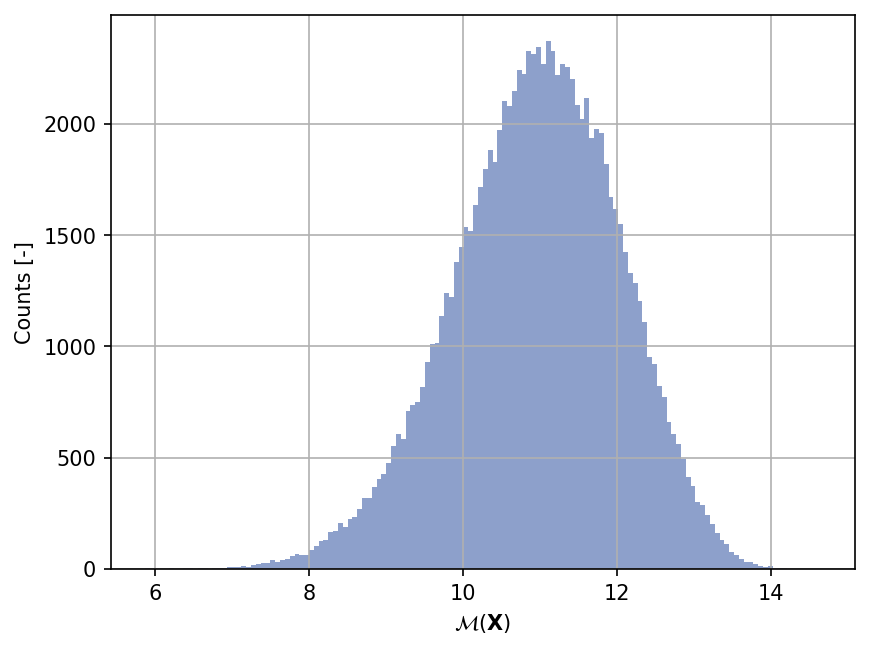

In [5]:
np.random.seed(42)
xx_test = my_testfun.prob_input.get_sample(100000)
yy_test = my_testfun(xx_test)

plt.hist(yy_test, bins="auto", color="#8da0cb");
plt.grid();
plt.ylabel("Counts [-]");
plt.xlabel("$\mathcal{M}(\mathbf{X})$");
plt.gcf().set_dpi(150);

### Moments estimation

Shown below is the convergence of a direct Monte-Carlo estimation of
the output mean and variance with increasing sample sizes.

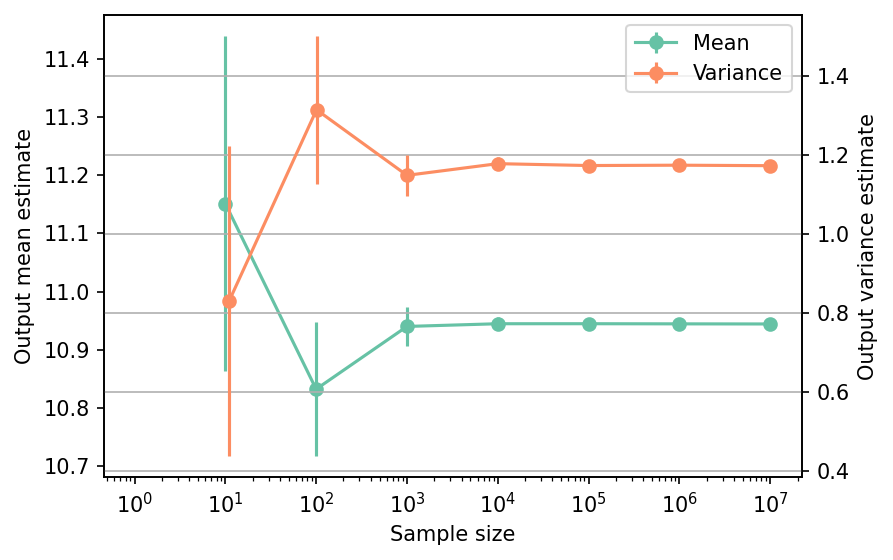

In [6]:
# --- Compute the mean and variance estimate
np.random.seed(42)
sample_sizes = np.array([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], dtype=int)
mean_estimates = np.empty(len(sample_sizes))
var_estimates = np.empty(len(sample_sizes))

for i, sample_size in enumerate(sample_sizes):
    xx_test = my_testfun.prob_input.get_sample(sample_size)
    yy_test = my_testfun(xx_test)
    mean_estimates[i] = np.mean(yy_test)
    var_estimates[i] = np.var(yy_test)

# --- Compute the error associated with the estimates
mean_estimates_errors = np.sqrt(var_estimates) / np.sqrt(np.array(sample_sizes))
var_estimates_errors = var_estimates * np.sqrt(2 / (np.array(sample_sizes) - 1))

# --- Do the plot
fig, ax_1 = plt.subplots(figsize=(6,4))

ax_1.errorbar(
    sample_sizes,
    mean_estimates,
    yerr=mean_estimates_errors,
    marker="o",
    color="#66c2a5",
    label="Mean",
)
ax_1.set_xlabel("Sample size")
ax_1.set_ylabel("Output mean estimate")
ax_1.set_xscale("log");
ax_2 = ax_1.twinx()
ax_2.errorbar(
    sample_sizes + 1,
    var_estimates,
    yerr=var_estimates_errors,
    marker="o",
    color="#fc8d62",
    label="Variance",
)
ax_2.set_ylabel("Output variance estimate")

# Add the two plots together to have a common legend
ln_1, labels_1 = ax_1.get_legend_handles_labels()
ln_2, labels_2 = ax_2.get_legend_handles_labels()
ax_2.legend(ln_1 + ln_2, labels_1 + labels_2, loc=0)

plt.grid()
fig.set_dpi(150)

The tabulated results for each sample size is shown below.

In [7]:
from tabulate import tabulate

# --- Compile data row-wise
outputs = []
for (
    sample_size,
    mean_estimate,
    mean_estimate_error,
    var_estimate,
    var_estimate_error,
) in zip(
    sample_sizes,
    mean_estimates,
    mean_estimates_errors,
    var_estimates,
    var_estimates_errors,
):
    outputs += [
        [
            sample_size,
            mean_estimate,
            mean_estimate_error,
            var_estimate,
            var_estimate_error,
            "Monte-Carlo",
        ],
    ]

header_names = [
    "Sample size",
    "Mean",
    "Mean error",
    "Variance",
    "Variance error",
    "Remark",
]

tabulate(
    outputs,
    headers=header_names,
    floatfmt=(".1e", ".4e", ".4e", ".4e", ".4e", "s"),
    tablefmt="html",
    stralign="center",
    numalign="center",
)

'<table>\n<thead>\n<tr><th style="text-align: center;"> Sample size </th><th style="text-align: center;">   Mean   </th><th style="text-align: center;"> Mean error </th><th style="text-align: center;"> Variance </th><th style="text-align: center;"> Variance error </th><th style="text-align: center;">  Remark   </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: center;">   1.0e+01   </td><td style="text-align: center;">1.1151e+01</td><td style="text-align: center;"> 2.8825e-01 </td><td style="text-align: center;">8.3090e-01</td><td style="text-align: center;">   3.9169e-01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+02   </td><td style="text-align: center;">1.0832e+01</td><td style="text-align: center;"> 1.1468e-01 </td><td style="text-align: center;">1.3151e+00</td><td style="text-align: center;">   1.8692e-01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+03   </td><td style="text-align: center;">1.0940e+01</td><td style="text-align: center;"> 3.3899e-02 </td><td style="text-align: center;">1.1492e+00</td><td style="text-align: center;">   5.1418e-02   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+04   </td><td style="text-align: center;">1.0945e+01</td><td style="text-align: center;"> 1.0857e-02 </td><td style="text-align: center;">1.1787e+00</td><td style="text-align: center;">   1.6670e-02   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+05   </td><td style="text-align: center;">1.0945e+01</td><td style="text-align: center;"> 3.4263e-03 </td><td style="text-align: center;">1.1739e+00</td><td style="text-align: center;">   5.2500e-03   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+06   </td><td style="text-align: center;">1.0944e+01</td><td style="text-align: center;"> 1.0839e-03 </td><td style="text-align: center;">1.1748e+00</td><td style="text-align: center;">   1.6615e-03   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+07   </td><td style="text-align: center;">1.0944e+01</td><td style="text-align: center;"> 3.4258e-04 </td><td style="text-align: center;">1.1736e+00</td><td style="text-align: center;">   5.2484e-04   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n</tbody>\n</table>'

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```